In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from cblearn.embedding import SOE
import pandas as pd
import numpy as np
from sklearn.base import ClassifierMixin, TransformerMixin
from sklearn.ensemble._bagging import BaseBagging
from cblearn.embedding import SOE
from cblearn.utils import check_query_response
from sklearn.utils.validation import check_is_fitted

from .analyse_embeddings import SUBJ_LIST, get_trial_df, preprocess_queries


sns.set_theme(style="whitegrid")
font = {'family' : 'sans-serif',
        #'fontname': 'Helvetica',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [ ]:
def _align_embeddings(embeddings, return_disparity=True, standardize_rotation=True):
    from scipy.linalg import orthogonal_procrustes
    from sklearn.utils import check_array

    reference = check_array(embeddings[0], copy=True)
    others = [check_array(e, copy=True) for e in embeddings[1:]]

    # standardize the reference embedding: translation, scale, rotation
    reference -= reference.mean()
    reference /= np.linalg.norm(reference)
    if standardize_rotation:
        U, S, _ = np.linalg.svd(reference, full_matrices=False)
        # flip sign based on absolute value for deterministic results
        max_abs = np.argmax(np.abs(U), axis=0)
        signs = np.sign(U[max_abs, range(U.shape[1])])
        reference = U * S * signs

    # align others translation, scale, rotation
    for other in others:  # inplace operations
        other -= other.mean()
        other /= np.linalg.norm(other)
        R, scale = orthogonal_procrustes(reference, other)
        other[:] = scale * (other @ R.T)

    if return_disparity:
        disparities = np.array([((reference - other)**2).sum() for other in others])
        return np.array([reference] + others), disparities
    else:
        return np.array([reference] + others)


class BootstrapEmbedding(TransformerMixin, ClassifierMixin, BaseBagging):
    def __init__(
        self,
        estimator=None,
        n_estimators=10,
        *,
        max_samples=1.0,
        bootstrap=True,
        oob_score=False,
        warm_start=False,
        n_jobs=None,
        random_state=None,
        verbose=0,
    ):
        super().__init__(
            estimator=estimator,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=1.0,
            bootstrap=bootstrap,
            bootstrap_features=False,
            oob_score=oob_score,
            warm_start=warm_start,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose,
            base_estimator="deprecated",
        )

    def _validate_estimator(self):
        """Check the estimator and set the estimator_ attribute."""
        super()._validate_estimator(default=SOE())
        
    def _set_oob_score(self, X, y):
        """Based on sklearn.ensemble.BaggingClassifier._set_oob_score"""
        raise NotImplementedError
            
    def aligned_embeddings(self, return_disparity=False):
        check_is_fitted(self)
        embeddings = [e.embedding_ for e in self.estimators_]
        return _align_embeddings(embeddings, return_disparity=return_disparity)

    def transform(self, X=None):
        return self.aligned_embeddings().mean(axis=0)


def plot_ci_embedding(embeddings, subj, ax, legend):
    if embeddings[:, 0].mean() > embeddings[:, -1].mean():
        embeddings

    ax.set_xticks([-5,-2.5,0,2.5,5])
    df = pd.DataFrame(embeddings.reshape(-1, 11)).melt(value_name='perceived', var_name='object_ix').set_index('object_ix').join(objects)
    common = dict(y='perceived', dashes=False, linestyle='', 
                  estimator='mean', errorbar=('pi', 95), err_style='bars', legend=legend, ax=ax)
    sns.lineplot(df[df['add']==0], x='sph', label='Add: 0 dpt',color=sns.color_palette("Blues")[-2], marker='D', **common)
    sns.lineplot(df[df['add']==1], x=df[df['add']==1].sph-0.1, label='Add: 1 dpt',color=sns.color_palette("Greens")[-2], marker='o', **common)
    sns.lineplot(df[df['add']==3], x=df[df['add']==3].sph+0.1, label='Add: 1 dpt',color=sns.color_palette("Oranges")[-2], marker='s', **common)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f"Observer {subj}")

Starting with subject: 3
Starting with subject: 4
Starting with subject: 5
Starting with subject: 7
Starting with subject: 8
Starting with subject: 9
Starting with subject: 10
Starting with subject: 11
Starting with subject: 12
Starting with subject: 13
Starting with subject: 14
Starting with subject: 15
Starting with subject: 16


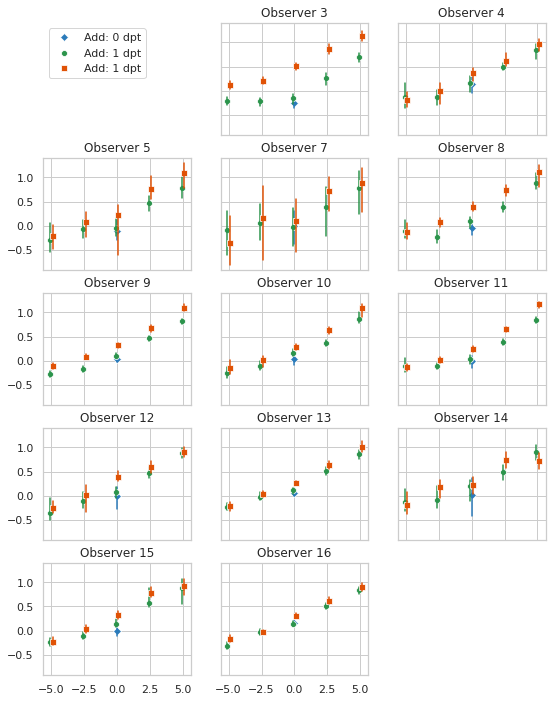

In [ ]:
df = pd.read_pickle('./data/scaling.pkl')
wide_df = pd.pivot(df, columns=['sph', 'add'], index=['subj'])
zero_index = wide_df.columns.get_loc(('scaling', 0.0, 0.0))
max_index = wide_df.columns.get_loc(('scaling', 5.0, 3.0))
df = df.set_index(['subj', 'sph', 'add'])

fig, axs = plt.subplots(int(np.ceil(len(SUBJ_LIST) / 3)), 3, sharex=True, sharey=True, figsize=(9, 12))
# big axis for common labels
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Sph (dpt)")
plt.ylabel("Perceived distortions")

for subj, ax in zip(SUBJ_LIST, axs.flat[1:]):
    print("Starting with subject: " + str(subj))
    data = get_trial_df(subj)
    objects, queries = preprocess_queries(data)
    triplets, responses = check_query_response(queries, result_format='list-count')
    bsSOE1d = BootstrapEmbedding(estimator=SOE(1), n_estimators=1000, n_jobs=4)
    bsSOE1d.fit(triplets, responses)
    scales = bsSOE1d.aligned_embeddings()
    if scales[:, 0].mean() > scales[:, -1].mean():
        scales = -scales
    # first standardize (sph=0, add=0) -> 0.0, (sph=5, add=3) -> 1.0
    scales = (scales - scales[:, zero_index].mean()) / (scales[:, max_index].mean() - scales[:, zero_index].mean())
    # then apply offset to 0.0 and 1.0 according to full embedding
    scales = scales * (df.scaling.loc[(subj, 5.0, 3.0)] - df.scaling.loc[(subj, 0.0, 0.0)]) + df.scaling.loc[(subj, 0.0, 0.0)]

    plt.sca(ax)
    plot_ci_embedding(scales, subj, ax, legend=(subj == SUBJ_LIST[0]))


fig.delaxes(axs.flat[0])
for ax in axs.flat[(1 + len(SUBJ_LIST)):]:
    fig.delaxes(ax)
handles, labels = axs.flat[1].get_legend_handles_labels()
bigax = fig.add_subplot(111, frameon=False)
bigax.legend(handles=handles, labels=labels, loc='upper left')
bigax.set_xticks([])
bigax.set_yticks([])
axs.flat[1].get_legend().remove()

fig.savefig('plots/embedding_CI.pdf')
plt.show()